## Markov Chain Sessions Baseline

The goal of the notebook is to predict next session type by learning the transition probabilities between (w)ork and (p)lay states using a Markov chain model.

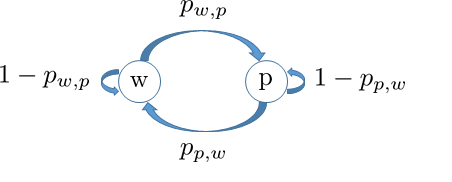

In [1]:
from IPython.display import Image
Image("figures/markov_chain.png")

Let $x_1,...,x_n$ be an observed sequence of transitions then we can write down the probability of sequence occurence as follows:

\begin{eqnarray}
\log p(x_1,...,x_n) &=& \log \big[p(x(1)=x_1 \prod_{t=1}^{n} p(x(t+1)=x_t | x(t)=x_t) \big] \nonumber \\
&=& \log q(x_1) + \sum_{t=1}^{n-1}\log p_{x_t,x_{t+1}} \nonumber \\
&=& \log q(x_1) + \sum_{(i,j)}\hat{n}(i,j)\log p(i,j) \nonumber
\end{eqnarray}

We can estimate the transition probabilities between sessions using Maximum Likelihood Estimator (MLE) where $\hat{n}(i,j)$ is the number of observed transitions from i to j:

$$\hat{p}_{\mathrm{mle}}(i,j) = \frac{\hat{n}(i,j)}{\sum_{k}\hat{n}(i,k)}$$

Let's start by importing the required libraries:

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from numpy import linalg as LA

import warnings
warnings.filterwarnings('ignore')

In [3]:
#load data
print("loading App data...")
train_df = pd.read_csv('./data/AppResult.csv', sep=',')
train_df.head()

loading App data...


,DateTime,Process,Label
0,2019-08-01 11:39:08.462313,System Idle Process,work
1,2019-08-01 11:39:08.479314,System,work
2,2019-08-01 11:39:08.517314,Secure System,work
3,2019-08-01 11:39:08.551314,Registry,work
4,2019-08-01 11:39:08.580315,smss.exe,work


Let's convert start and end times to pandas datetime:

In [4]:
train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])
train_df.columns = ['Start', 'Process', 'Label']
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 3 columns):
Start      1604 non-null datetime64[ns]
Process    1604 non-null object
Label      1604 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 37.7+ KB


In [5]:
train_df['target'] = train_df['Label'].map({'work': 1, 'play':0})
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head(10)

,Start,Process,Label,target
0,2019-08-01 11:40:11.380576,svchost.exe,work,1
1,2019-08-01 11:46:02.269715,NVDisplay.Container.exe,play,0
2,2019-08-01 11:46:04.754598,RuntimeBroker.exe,play,0
3,2019-08-01 11:46:04.914589,hvsirpcd.exe,play,0
4,2019-08-01 11:39:11.403311,svchost.exe,work,1
5,2019-08-01 11:39:21.655992,svchost.exe,work,1
6,2019-08-01 11:52:57.017394,conhost.exe,play,0
7,2019-08-01 11:46:03.487658,CcmExec.exe,play,0
8,2019-08-01 11:40:13.274094,RuntimeBroker.exe,work,1
9,2019-08-01 11:40:18.099087,CredentialUIBroker.exe,work,1


In [6]:
transitions = train_df['target'].values
transitions

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

Let's compute the number of observed transitions $n(i,j)$ based on training data:

In [7]:
nij = np.zeros((2,2))
for idx in range(len(transitions)-1):
    cur = transitions[idx]
    nxt = transitions[idx+1]
    
    if (cur == 0 and nxt == 0):
        nij[0,0] += 1
    elif (cur == 0 and nxt == 1):
        nij[0,1] += 1
    elif (cur == 1 and nxt == 0):
        nij[1,0] += 1
    elif (cur == 1 and nxt == 1):
        nij[1,1] += 1
    else:
        continue
#end for
print("transition counts: ")
print(nij)

transition counts: 
[[185. 353.]
 [353. 712.]]


In [8]:
p_mle = np.zeros((2,2))
p_mle[0,0] = nij[0,0]/np.sum(nij[0,:])
p_mle[0,1] = nij[0,1]/np.sum(nij[0,:])
p_mle[1,0] = nij[1,0]/np.sum(nij[1,:])
p_mle[1,1] = nij[1,1]/np.sum(nij[1,:])
print("transition probabilities: ")
print(p_mle)

transition probabilities: 
[[0.34386617 0.65613383]
 [0.3314554  0.6685446 ]]


Let's look at the eigen value of the transition matrix:

In [9]:
w, v = LA.eig(p_mle)
print(w)
print(v)

[0.01241077 1.        ]
[[-0.89257577 -0.70710678]
 [ 0.45089743 -0.70710678]]


Let's use the transition probability matrix to simulate the markov chain. We can define the initial probability of being in work and play states as p_init:

In [16]:
p_init = np.array([0.8, 0.2])
p_cur = p_init
num_transitions = 50
gen_sequence = []
for idx in range(num_transitions):
    p_nxt = np.dot(p_mle, p_cur)
    p_cur = p_nxt
    state = np.argmax(p_nxt)
    gen_sequence.append(state)
#end for
print("current transition probability vector:")
print(p_nxt)
print("generated sequence (0: play, 1: work): ")
print(gen_sequence)

current transition probability vector:
[0.40137243 0.40137243]
generated sequence (0: play, 1: work): 
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


No handles with labels found to put in legend.


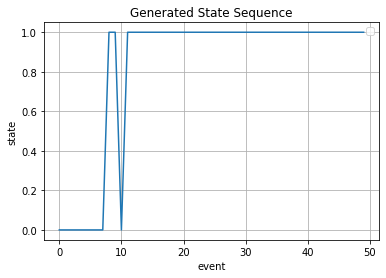

In [25]:
plt.plot(gen_sequence)
plt.title("Generated State Sequence"); plt.xlabel("event"); plt.ylabel('state'); plt.grid(True); plt.legend()

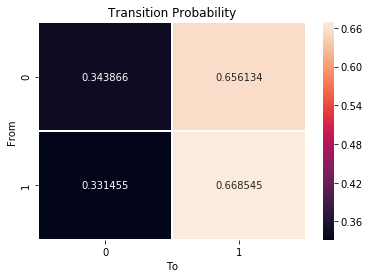

In [24]:
sns.heatmap(p_mle, annot=True, fmt="f", linewidths=.5)
plt.title("Transition Probability"); plt.xlabel("To"); plt.ylabel("From");

### References

[1] J. Kingman, "Poisson Processes", Oxford Studies in Probability, Clarendon Press, 1993  
[2] A. Patil et al. PyMC: Bayesian Stochastic Modelling in Python, Journal of Statistical Software, 2010